<a href="https://colab.research.google.com/github/taresh18/Image-Colorization/blob/main/ImColor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from skimage.color import rgb2lab, lab2rgb

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(123)

In [ ]:
from utils import*
from model_utils import*


In [ ]:
data_path = 'data/train2017'

In [ ]:
# randomly selecting 10k images (8k training and 2k validation)
img_paths = glob.glob(data_path + "/*.jpg") 
img_paths_sub = np.random.choice(img_paths, 10000, replace=False) 
rand_ids = np.random.permutation(10000)
train_ids = rand_ids[:8000] 
train_paths = img_paths_sub[train_ids]
val_ids = rand_ids[8000:] 
val_paths = img_paths_sub[val_ids]
print("Train size: ", len(train_paths))
print("Val size: ", len(val_paths))

Train size:  8000
Val size:  2000


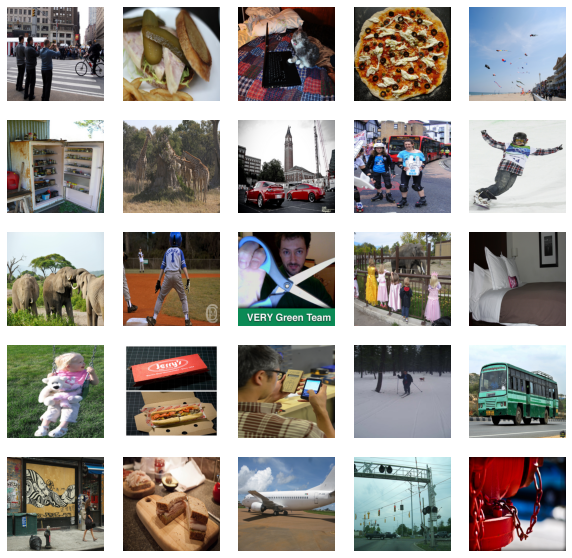

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), facecolor='white', squeeze=True)
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path), aspect='auto')
    ax.axis("off")

In [ ]:
lr_G = 0.0002
lr_d = 0.0002
beta1=0.5
beta2=0.999
lamda = 100.
batch_size = 16
img_size = 256
num_epochs = 5

In [ ]:
# Preparing the train and val dataloaders
train_dataset = make_data(data_path=train_paths, split='train')
val_dataset = make_data(data_path=val_paths, split='val')
train_dl = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
print(len(train_dl), len(val_dl))

500 125


In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet34
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_generator(n_input=1, n_output=2, size=img_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = create_body(resnet34, pretrained=True, n_in=n_input, cut=-2)
    G_net = DynamicUnet(backbone, n_output, (size, size)).to(device)
    return G_net

In [ ]:
def pretrain_generator(G_net, train_dl, opt, criterion, num_epochs):
    for itr in range(num_epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = G_net(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {itr + 1}/{num_epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

G_net = build_generator(n_input=1, n_output=2, size=img_size)
opt = optim.Adam(G_net.parameters(), lr=0.0004)
criterion = nn.L1Loss()        
pretrain_generator(G_net, train_dl, opt, criterion, num_epochs)


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/5
L1 Loss: 0.09098


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/5
L1 Loss: 0.08336


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/5
L1 Loss: 0.08291


100%|██████████| 500/500 [04:03<00:00,  2.05it/s]

Epoch 5/5
L1 Loss: 0.08263


In [ ]:
torch.save(G_net.state_dict(), "generator.pt")

In [ ]:
G_net = build_generator(n_input=1, n_output=2, size=img_size)
G_net.load_state_dict(torch.load("generator.pt", map_location=device))



<All keys matched successfully>

In [ ]:
# Architecture of the Discriminator model (PatchGAN)
Discriminator(4)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): S

Initializing the model with norm initialization


 80%|███████▉  | 399/500 [03:34<00:51,  1.95it/s]


Epoch 1/5
Iteration 400/500
loss_D_fake: 0.44844
loss_D_real: 0.45514
loss_D: 0.45179
loss_G_GAN: 1.98623
loss_G_L1: 8.96402
loss_G: 10.95026


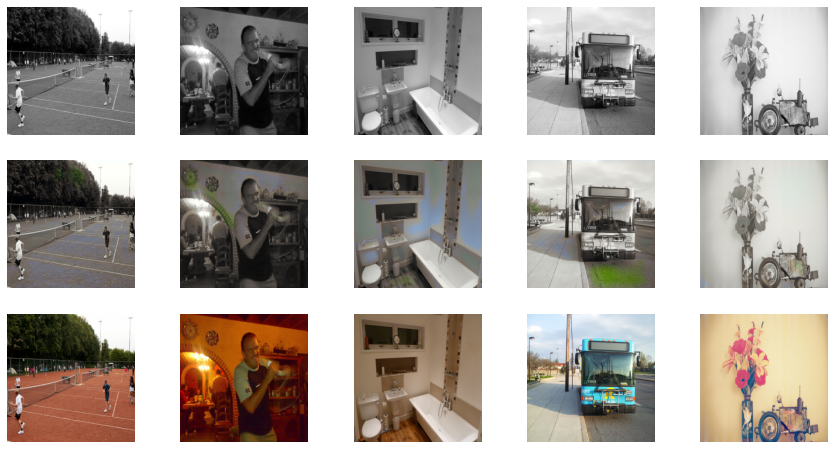

 40%|███▉      | 199/500 [01:46<02:37,  1.91it/s]


Epoch 2/5
Iteration 200/500
loss_D_fake: 0.54077
loss_D_real: 0.57644
loss_D: 0.55860
loss_G_GAN: 1.39543
loss_G_L1: 9.87601
loss_G: 11.27145


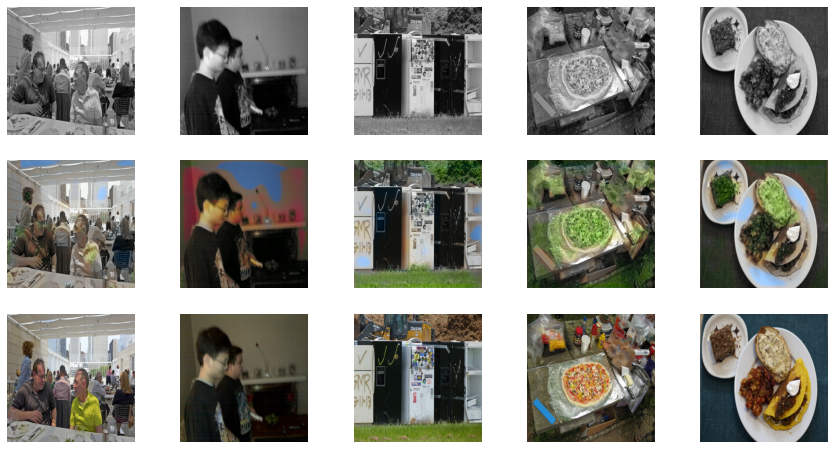

 80%|███████▉  | 399/500 [03:32<00:51,  1.97it/s]


Epoch 2/5
Iteration 400/500
loss_D_fake: 0.54661
loss_D_real: 0.57730
loss_D: 0.56196
loss_G_GAN: 1.35381
loss_G_L1: 9.86980
loss_G: 11.22361


/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


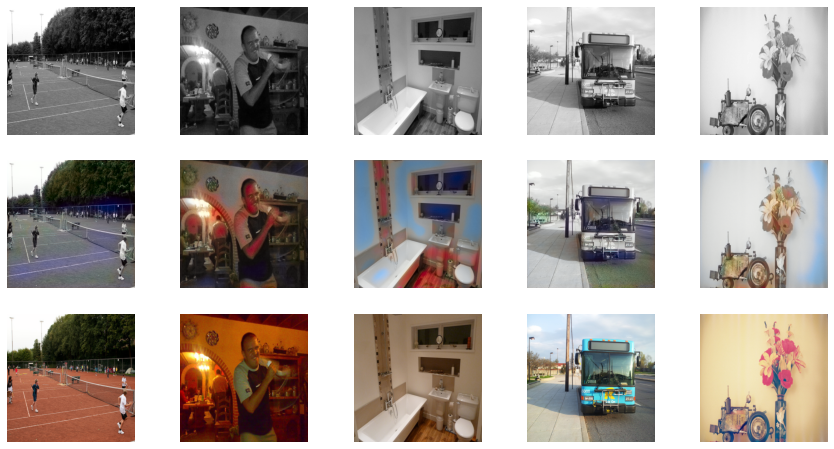

 40%|███▉      | 199/500 [01:45<02:36,  1.93it/s]


Epoch 3/5
Iteration 200/500
loss_D_fake: 0.55114
loss_D_real: 0.60565
loss_D: 0.57839
loss_G_GAN: 1.22996
loss_G_L1: 9.82136
loss_G: 11.05132


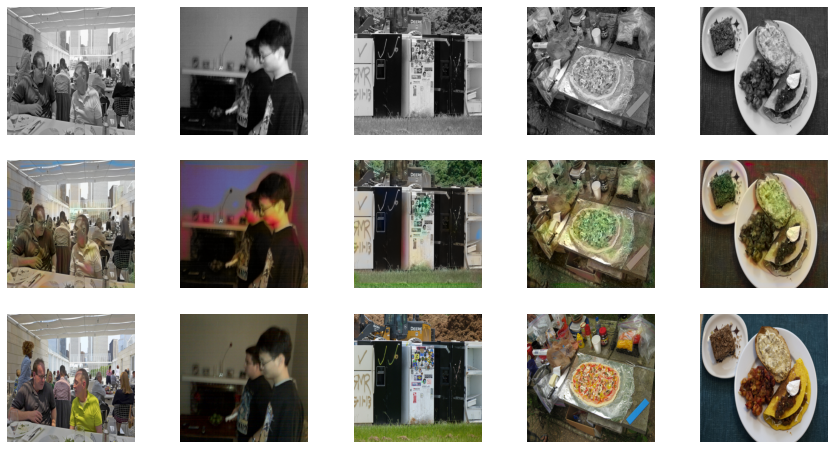

 80%|███████▉  | 399/500 [03:32<00:53,  1.88it/s]


Epoch 3/5
Iteration 400/500
loss_D_fake: 0.55516
loss_D_real: 0.60459
loss_D: 0.57988
loss_G_GAN: 1.22660
loss_G_L1: 9.84529
loss_G: 11.07189


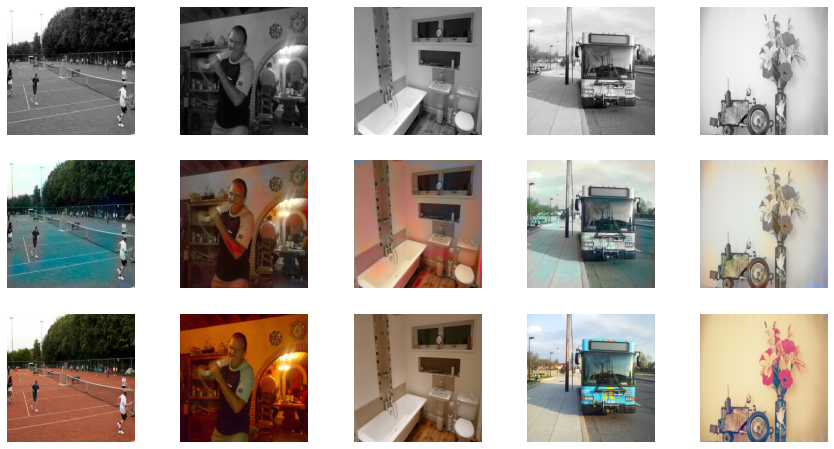

 40%|███▉      | 199/500 [01:48<02:41,  1.86it/s]


Epoch 4/5
Iteration 200/500
loss_D_fake: 0.53068
loss_D_real: 0.57471
loss_D: 0.55270
loss_G_GAN: 1.33887
loss_G_L1: 10.19835
loss_G: 11.53722


/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 153 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


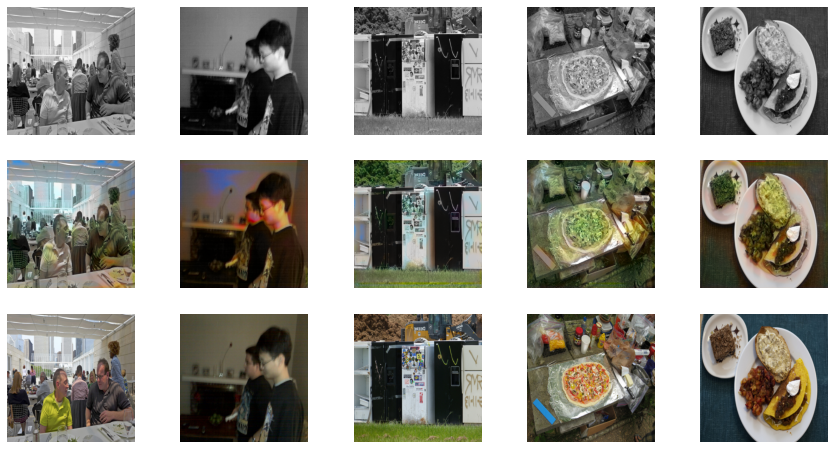

 80%|███████▉  | 399/500 [03:36<00:51,  1.95it/s]


Epoch 4/5
Iteration 400/500
loss_D_fake: 0.54725
loss_D_real: 0.59019
loss_D: 0.56872
loss_G_GAN: 1.27819
loss_G_L1: 10.04262
loss_G: 11.32081


/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 30 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


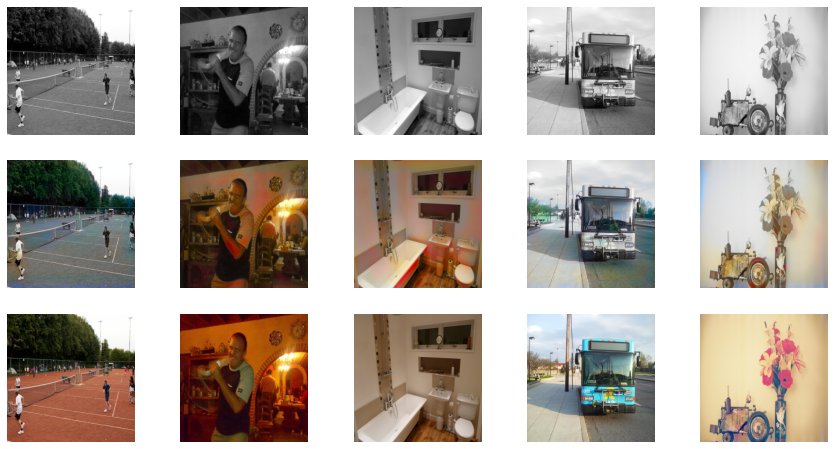

 40%|███▉      | 199/500 [01:46<02:38,  1.90it/s]


Epoch 5/5
Iteration 200/500
loss_D_fake: 0.54702
loss_D_real: 0.59550
loss_D: 0.57126
loss_G_GAN: 1.22657
loss_G_L1: 9.66470
loss_G: 10.89126


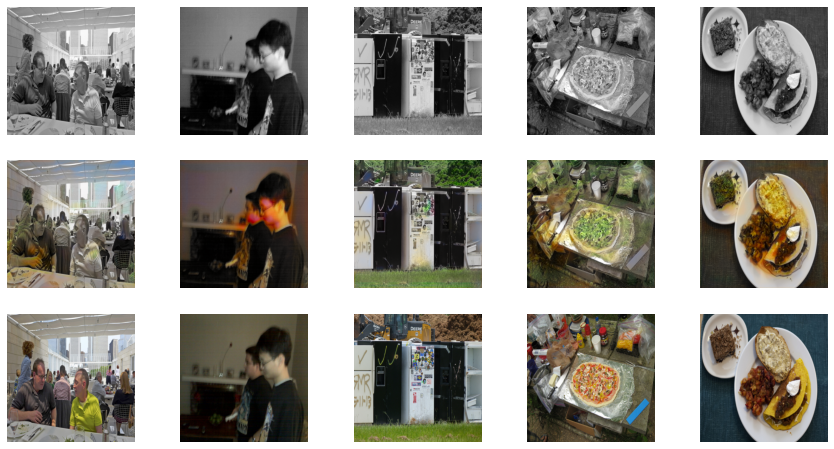

 80%|███████▉  | 399/500 [03:33<00:52,  1.93it/s]


Epoch 5/5
Iteration 400/500
loss_D_fake: 0.54555
loss_D_real: 0.59993
loss_D: 0.57274
loss_G_GAN: 1.22436
loss_G_L1: 9.71628
loss_G: 10.94064


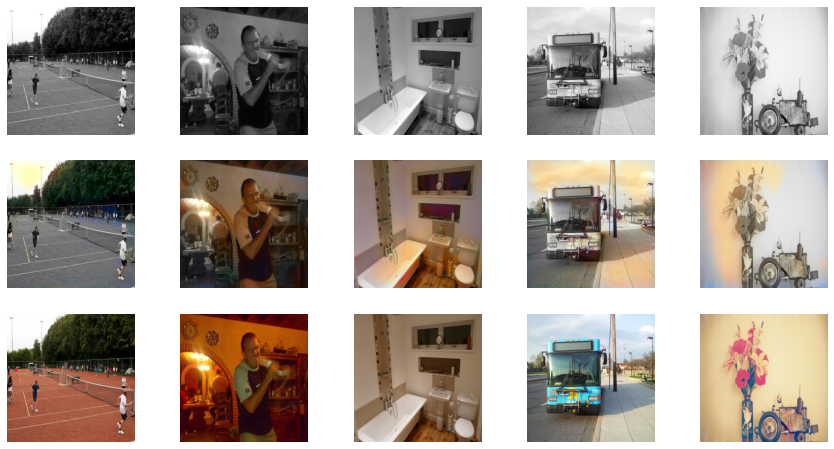

 96%|█████████▌| 480/500 [04:17<00:10,  1.95it/s]

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) 
    for itr in range(epochs):
        loss_meter_dict = create_loss_meters() 
        i = 0                                  
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) 
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {itr+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) 
                visualize(model, data, save=False) 

model = Model(G_net=G_net, lr_G=0.0004, lr_D=0.0004, beta1=0.5, beta2=0.999, lamda=100.)
train_model(model, train_dl, num_epochs)